Initial Data:
         Date   Price    Open    High     Low     Vol. Change %
0 2024-09-20  116.00  117.06  118.62  115.39  382.46M   -1.59%
1 2024-09-19  117.87  117.35  119.66  117.25  293.51M    3.97%
2 2024-09-18  113.37  115.89  117.70  113.22  310.32M   -1.92%
3 2024-09-17  115.59  118.17  118.80  114.83  231.93M   -1.02%
4 2024-09-16  116.78  116.79  118.18  114.36  248.77M   -1.95%
Data after cleaning:
         Date   Price    Open    High     Low         Vol.  Change %
0 2024-09-20  116.00  117.06  118.62  115.39  382460000.0     -1.59
1 2024-09-19  117.87  117.35  119.66  117.25  293510000.0      3.97
2 2024-09-18  113.37  115.89  117.70  113.22  310320000.0     -1.92
3 2024-09-17  115.59  118.17  118.80  114.83  231930000.0     -1.02
4 2024-09-16  116.78  116.79  118.18  114.36  248770000.0     -1.95
Data shape after cleaning: (2699, 7)
Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')
Random Forest - Root Mean Squared Error: 1.3774281832597

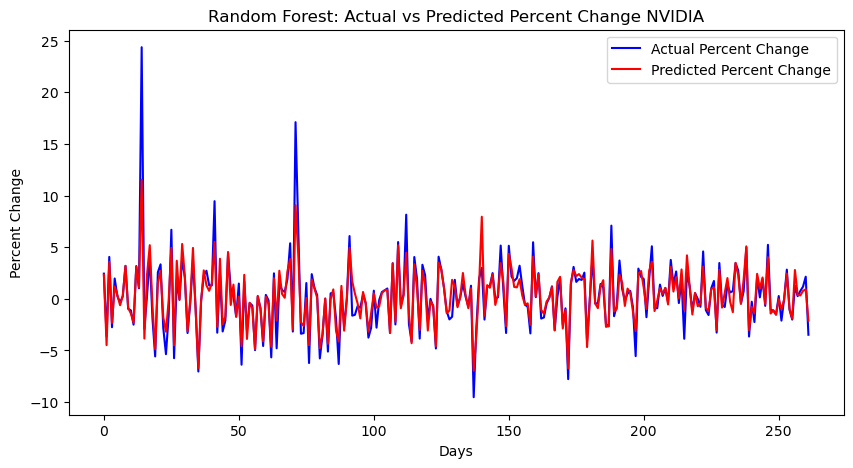

Linear Regression - Mean Absolute Error: 1.4697580269116544
Future predictions have been saved to nvda_predictions.csv


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import plotly.express as px


file_path = "nvda_data.csv"  # Update with your file path
data = pd.read_csv(file_path, parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Display the first few rows of the data
print("Initial Data:\n", data.head())

# Clean 'Change %' column
data['Change %'] = data['Change %'].str.replace('%', '').str.replace(',', '').astype(float)
data['Change %'] = pd.to_numeric(data['Change %'], errors='coerce')

# Clean 'Vol.' column
def convert_volume(volume):
    if isinstance(volume, str):
        if 'M' in volume:
            return float(volume.replace('M', ''))* 1e6
        elif 'K' in volume:
            return float(volume.replace('K', '')) * 1e3
        elif 'B' in volume:
            return float(volume.replace('B', '')) * 1e9
        else:
            return float(volume)
    elif isinstance(volume, float):
        return volume  # If already a float, return it unchanged
    else:
        return None

data['Vol.'] = data['Vol.'].apply(convert_volume)

print("Data after cleaning:\n", data.head())
print(f"Data shape after cleaning: {data.shape}")
print(data.columns)

# Step 1.1: Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Step 2: Feature Engineering
# Sort data by date
data = data.sort_values('Date')

# Create features based on past data
data['5_day_MA'] = data['Price'].rolling(window=5).mean()
data['10_day_MA'] = data['Price'].rolling(window=10).mean()
data['20_day_MA'] = data['Price'].rolling(window=20).mean()
data['1_day_lag'] = data['Price'].shift(1)
data['5_day_lag'] = data['Price'].shift(5)

# Lagged Percent Changes
for lag in [1, 2, 3, 5, 10]:
    data[f'Lag_Percent_Change_{lag}'] = data['Change %'].shift(lag)

# Moving Averages of Percent Change
for window in [5, 10, 20, 50, 100, 200]:
    data[f'SMA_Percent_Change_{window}'] = data['Change %'].rolling(window=window).mean()
    data[f'EMA_Percent_Change_{window}'] = data['Change %'].ewm(span=window, adjust=False).mean()

# Price Momentum
for period in [1, 5, 20]:
    data[f'Momentum_{period}'] = data['Change %'].pct_change(periods=period) * 100

# Volatility Measures of Percent Change
for window in [5, 10, 20]:
    data[f'Volatility_Percent_Change_{window}'] = data['Change %'].pct_change().rolling(window=window).std()

# Volume-Based Features
for period in [1, 5, 20]:
    data[f'Volume_Momentum_{period}'] = data['Vol.'].pct_change(periods=period) * 100

# On-Balance Volume (OBV)
data['OBV'] = (np.sign(data['Change %'].diff()) * data['Vol.']).fillna(0).cumsum()

# RSI Calculation using Percent Change
window_length = 14
delta = data['Change %'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# MACD Calculation using Percent Change
short_ema = data['Change %'].ewm(span=12, adjust=False).mean()
long_ema = data['Change %'].ewm(span=26, adjust=False).mean()
data['MACD'] = short_ema - long_ema

# Time-Based Features
data['Day_of_Week'] = data['Date'].dt.dayofweek
data['Month'] = data['Date'].dt.month
data['Quarter'] = data['Date'].dt.quarter

# Drop rows with missing values (from lag features)
data.dropna(inplace=True)

# Feature and Target Selection
features = data.drop(['Change %', 'Date'], axis=1)  # Remove the target variable and date column
target = data['Change %']

# Normalizing features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2, random_state=42)

# Step 4: Model Training
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Step 5: Model Evaluation
y_pred_rf = model_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print(f"Random Forest - Root Mean Squared Error: {rmse_rf}")

# Plotting the actual vs predicted percent changes
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual Percent Change', color='blue')
plt.plot(y_pred_rf, label='Predicted Percent Change', color='red')
plt.title('Random Forest: Actual vs Predicted Percent Change NVIDIA')
plt.xlabel('Days')
plt.ylabel('Percent Change')
plt.legend()
plt.show()

# Linear Regression - Model Training and Evaluation
features2 = ['5_day_MA', '10_day_MA', '20_day_MA', '1_day_lag', '5_day_lag', 'Vol.']
target2 = 'Price'

# Train-Test Split based on Date
train_data = data[data['Date'] < '2023-01-01']
test_data = data[data['Date'] >= '2023-01-01']

X_train2 = train_data[features2]
y_train2 = train_data[target2]
X_test2 = test_data[features2]
y_test2 = test_data[target2]

# Scale features
scaler = StandardScaler()
X_train_scaled2 = scaler.fit_transform(X_train2)
X_test_scaled2 = scaler.transform(X_test2)

# Train a linear regression model
model_lr = LinearRegression()
model_lr.fit(X_train_scaled2, y_train2)

# Predict on the test set
predictions_lr = model_lr.predict(X_test_scaled2)

# Evaluate the model
mae_lr = mean_absolute_error(y_test2, predictions_lr)
print(f"Linear Regression - Mean Absolute Error: {mae_lr}")

# Predict future values
last_known_date = data['Date'].max()
future_dates = pd.date_range(last_known_date + pd.Timedelta(days=1), periods=7)
future_features = []

for i, date in enumerate(future_dates):
    # last_5_day_ma = data['Price'].iloc[-5:].mean()
    # last_10_day_ma = data['Price'].iloc[-10:].mean()
    # last_20_day_ma = data['Price'].iloc[-20:].mean()
    # last_1_day_lag = data['Price'].iloc[-1]
    # last_5_day_lag = data['Price'].iloc[-5]
    # volume = data['Vol.'].iloc[-1]  # Corrected to use 'Vol.' as it is in the data
    last_5_day_ma = data['Price'].iloc[-5:].mean() + np.random.uniform(-1, 1) * (i+1)  # Add some variation
    last_10_day_ma = data['Price'].iloc[-10:].mean() + np.random.uniform(-1, 1) * (i+1)
    last_20_day_ma = data['Price'].iloc[-20:].mean() + np.random.uniform(-1, 1) * (i+1)
    
    last_1_day_lag = data['Price'].iloc[-1] + np.random.uniform(-1, 1)  # Introduce slight noise
    last_5_day_lag = data['Price'].iloc[-5] + np.random.uniform(-1, 1)
    
    volume = data['Vol.'].iloc[-1] + np.random.uniform(-1000, 1000)
    future_features.append([last_5_day_ma, last_10_day_ma, last_20_day_ma, last_1_day_lag, last_5_day_lag, volume])

# Scale future features
future_features_scaled = scaler.transform(future_features)

# Predict future prices
future_predictions_lr = model_lr.predict(future_features_scaled)

# Create a DataFrame for future predictions
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': future_predictions_lr
})

# # Plotting the actual vs predicted prices
# plt.figure(figsize=(12, 6))

# # Plotting actual prices from the CSV file
# plt.plot(data['Date'], data['Price'], label='Actual Prices', color='blue', linewidth=2)

# # Plotting future predicted prices
# plt.plot(future_predictions_df['Date'], future_predictions_df['Predicted_Price'], label='Predicted Prices', color='red', linestyle='--', marker='o')

# # Adding titles and labels
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('Actual vs Predicted Stock Prices')
# plt.legend()

# # Show grid for better visualization
# plt.grid(True)

# # Display the plot
# plt.show()

actual_prices_df = pd.DataFrame({
    'Date': data['Date'],
    'Price': data['Price']
})

# # Create the Plotly figure
# fig = px.line(actual_prices_df, x='Date', y='Price', title='Actual vs Predicted Stock Prices', labels={'Price': 'Price'}, line_shape='linear')

# # Add predicted prices to the same figure
# fig.add_scatter(x=future_predictions_df['Date'], y=future_predictions_df['Predicted_Price'], mode='lines+markers', name='Predicted Prices', line=dict(dash='dash', color='red'))

# # Update layout for better aesthetics
# fig.update_layout(
#     xaxis_title='Date',
#     yaxis_title='Price',
#     legend_title='Legend',
#     hovermode='x unified'
# )

# # Show the figure
# fig.show()

future_predictions_df['High'] = future_predictions_df['Predicted_Price'] * (1 + np.random.uniform(0.01, 0.02, len(future_predictions_df)))
future_predictions_df['Low'] = future_predictions_df['Predicted_Price'] * (1 - np.random.uniform(0.01, 0.02, len(future_predictions_df)))

# Adding a placeholder for volume - Assuming a random variation around the last known volume
last_known_volume = data['Vol.'].iloc[-1]  # Replace with your last known volume
future_predictions_df['volume'] = last_known_volume * np.random.uniform(0.95, 1.05, len(future_predictions_df))

# Calculating the % change - As we don't have previous days' data, use random small changes as a placeholder
# If you want actual % change based on the previous day's price, you should have those values as well.
future_predictions_df['Change %'] = np.random.uniform(-1, 1, len(future_predictions_df))  # Random small changes

# Save the predictions to a CSV file
output_file = "nvda_predictions.csv"  # Define the output file name
future_predictions_df.to_csv(output_file, index=False)

print(f"Future predictions have been saved to {output_file}")